In this exercise, you will build a convolutional neural network (CNN) to classify handwritten digits from the MNIST dataset. The steps to build this CNN classifier with PyTorch are provided in section 22.1 of  Machine Learning with Python Cookbook 2nd Edition. The steps to do this with TensorFlow are outlined in section 20.15 of the Machine Learning with Python Cookbook 1st Edition or at various web links, e.g., https://www.kaggle.com/code/amyjang/tensorflow-mnist-cnn-tutorial. Keep in mind that your code may need to be modified depending on your library versions of PyTorch, Keras, and Tensorflow.

Perform the following steps for this exercise.

1. Load the MNIST data set.

In [28]:
import torch
import torchvision

# Prevent randomness to ensure retestability
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Mean and Standard Error were obtained from online sources
mnist_mean = 0.1307
mnist_stderr = 0.3081

# Set up a transformation for when we download the data
transform = torchvision.transforms.Compose([

    # Convert images to tensors
    torchvision.transforms.ToTensor(),
    
    # Normalize with mean and std
    torchvision.transforms.Normalize((mnist_mean,), (mnist_stderr,))
])

# Obtain the MNIST train & test datasets using our transformation
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Build the data loaders.
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

2. Display the first five images in the training data set (see section 8.1 in the Machine Learning with Python Cookbook). Compare these to the first five training labels.

Shape of examples:  torch.Size([64, 1, 28, 28])


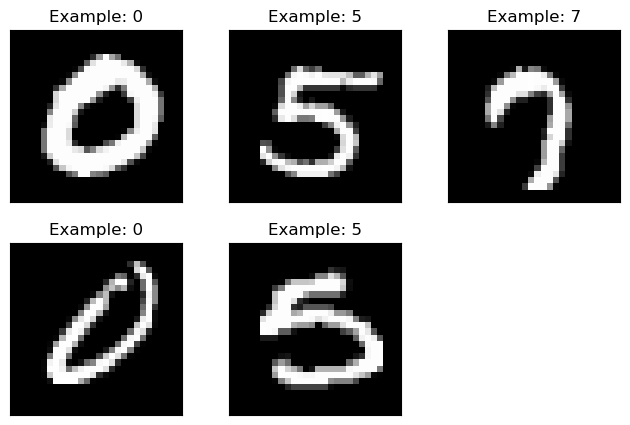

In [23]:
# Obtain our first batch.
examples = enumerate(test_loader)
batch_idx, (example_data, example_target) = next(examples)
print("Shape of examples: ",example_data.shape)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(5): # First five examples
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Example: {}".format(example_target[i]))
  plt.xticks([])
  plt.yticks([])

3. Build and train a Keras CNN classifier on the MNIST training set.

In [73]:
import warnings
warnings.filterwarnings('ignore')

import torch.nn as nn
import torch.nn.functional as nnf
import torch.optim as optim
import openvino.torch

# Adapted from textbook
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1,32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32,64, kernel_size=3, padding=1)
    self.drop1 = nn.Dropout2d(0.25)
    self.drop2 = nn.Dropout2d(0.5)
    self.line1 = nn.Linear(64*14*14,128)
    self.line2 = nn.Linear(128,10)

  def forward(self, x):
    x = nn.functional.relu(self.conv1(x))
    x = nn.functional.relu(self.conv2(x))
    x = nnf.max_pool2d(self.drop1(x),2)
    x = torch.flatten(x, 1)
    x = nnf.relu(self.line1(self.drop2(x)))
    x = self.line2(x)
    return nnf.log_softmax(x, dim=1) # activate

# Select the device ot run the model on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create our model with our device
model = Net().to(device)
optimizer = optim.Adam(model.parameters())

# I had challenges compiling this model on Windows due to a 
# pytorch bug: https://github.com/pytorch/pytorch/issues/135954
# I was able to modify the backends and get it to compile using 
# 'openvino' and then skip compilation on subsequent runs using 
# 'cudagraphs' (since it is running on CPU)
# torch._dynamo.list_backends()
model = torch.compile(model, backend='cudagraphs')

# Train the model
model.train()
for idx, (data,target) in enumerate(train_loader):
  data = data.to(device)
  target = target.to(device)
  optimizer.zero_grad()
  output = model(data)
  loss = nnf.nll_loss(output,target)
  loss.backward()
  optimizer.step()

skipping cudagraphs due to skipping cudagraphs due to cpu device. Found from : 
   File "C:\Users\15027\AppData\Local\Temp\ipykernel_12488\1734809149.py", line 21, in forward
    x = nn.functional.relu(self.conv1(x))

skipping cudagraphs due to skipping cudagraphs due to cpu device. Found from : 
   File "C:\Users\15027\AppData\Local\Temp\ipykernel_12488\1734809149.py", line 21, in forward
    x = nn.functional.relu(self.conv1(x))



4. Report the test accuracy of your model.

In [76]:
# Test the model
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    data,target = data.to(device), target.to(device)
    output = model(data)
    # get the index of the max log-probability
    test_loss += nn.functional.nll_loss(
      output, target, reduction='sum'
    ).item() # sum up batch loss
    pred = output.argmax(dim=1,keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()

test_total = len(test_loader.dataset)
print("On the first pass, there were only 1,085/10,000 correct, with a test loss of 2.35")
print("After iterating (below) there are correct: ",correct," of ",test_total,". Test Loss = ",(test_loss/test_total))


On the first pass, there were only 1,085/10,000 correct, with a test loss of 2.35
After iterating (below) there are correct:  9847  of  10000 . Test Loss =  0.04368605763204396


In [83]:
# Here is another training/test loop that allows us to 
# train the model further.
# https://nextjournal.com/gkoehler/pytorch-mnist

n_epochs = 3
log_interval = 10

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = nnf.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), 'wk11_model.pth')
      torch.save(optimizer.state_dict(), 'wk11_optimizer.pth')

def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += nnf.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      print(pred,target)
      from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
      cm = confusion_matrix(pred, target)
      ConfusionMatrixDisplay(cm).plot()

      break
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [67]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 1.8167, Accuracy: 4944/10000 (49%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.787303
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.789982
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.233046
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.528525
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.332181
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.505139
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.346914
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.462374
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.279321
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.162381
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.189181
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.310861
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.185528
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.415371
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.107939
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.334561
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.152601
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.057292
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.192610
Train Epoch: 1 [12160

#### Discussion

The accuracy started out fairly low (10.9%). By iterating through the training data several times we were able to get the accuracy up to 9892/10000 (99%).

5. Display a confusion matrix on the test set classifications.

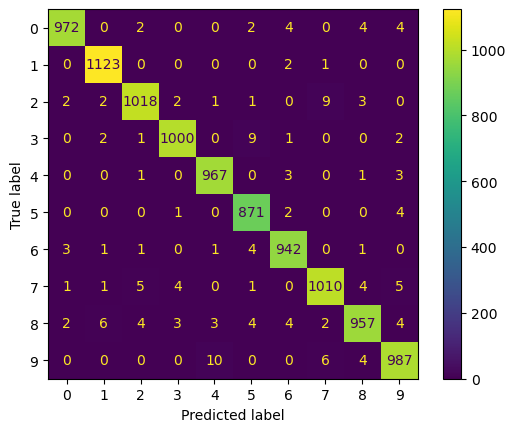

In [87]:
preds = None
targets = None

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        if preds is None:
            preds = pred
        else:
            preds = torch.cat((preds,pred))
        if targets is None:
            targets = target
        else:
            targets = torch.cat((targets,target))
        
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(preds, targets)
ConfusionMatrixDisplay(cm).plot()


6. Summarize your results.

CNN, and neural networks in general, are very complicated but tools like PyTorch make them relatively simple. Our model used rectified linear units (RELU), convolutional layers, and a dropout layer for regularization. I saw several arrangements of these layers in examples online, but I used the arrangement from our textbook. Obviously, arranging these layers differently would create a different CNN that would behave differently. On the first pass through the training data, the CNN only learned a little and got 11% accuracy. However, four times through the training data caused it to increase the accuracy to 99%. In the confusion matrix, you can see that "4" and "9" are mistaken for each other the most, and "3" and "5" also have a higher error rate. Overall, the model did an excelent job of classifying these images.